In [1]:
import networkx as nx
import csv
from matplotlib import pyplot as plt
import numpy as np
import json

In [2]:
INTRA = 1
INTER = 2
NODE_ATTR = "class"
EDGE_ATTR = "type"

## Labels reading

In [3]:
labels = dict()
with open('dataset/journal.pone.0023176.s005.TXT') as label_f:
    raw_labels = csv.reader(label_f, delimiter='\t')
    for r in raw_labels:
        assert int(r[0]) not in labels 
        labels[int(r[0])] = r[1]

#### Classes' name

In [4]:
CLASSES = set(labels.values())

## Functions 

In [5]:
def extract_subgraphs(origin_graph, classes=CLASSES):
    class_graphs = dict()
    for cl in classes:
        if cl == "teachers":
            continue
        
        class_members = [n for n, att in origin_graph.nodes(data=True) if att[NODE_ATTR] == cl]

        neighbours = list()
        for m in class_members:
            neighbours.extend(list(nx.ego_graph(origin_graph, m).nodes))
    
        stakeholders = class_members + neighbours
        stakeholders = filter(lambda x: origin_graph.nodes[x][NODE_ATTR] != "teachers", stakeholders)
        class_graphs[cl] = nx.Graph(nx.subgraph(origin_graph, list(stakeholders))) # make a copy of the subgraph
    
        edge_labels = {tuple(sorted(e)) : INTRA if(e[0] in class_members and e[1] in class_members) else INTER for e in class_graphs[cl].edges}
    
        # Checks
        graph_members_edges = list(map(lambda x: tuple(sorted(x)), nx.subgraph(origin_graph, list(class_members)).edges))
        INTRA_edges = [e for e, att in edge_labels.items() if att == INTRA]
        INTER_edges = [e for e, att in edge_labels.items() if att == INTER]
        edges = list(map(lambda x: tuple(sorted(x)), class_graphs[cl].edges))
    
        # graph_members_edges = INTRA_edges
        assert(len(set(graph_members_edges) - set(INTRA_edges)) == 0 and len(graph_members_edges) == len(INTRA_edges))
    
        # INTER_edges = edges - INTRA_edges
        assert(len(set(INTER_edges) - (set(edges) - set(INTRA_edges))) == 0 and len(INTER_edges) == len(edges) - len(INTRA_edges))
    
        nx.set_edge_attributes(class_graphs[cl], edge_labels, EDGE_ATTR)
        assert(len(nx.get_edge_attributes(class_graphs[cl], EDGE_ATTR).values()) == len(edge_labels))
    
        # Remove edges which are not at least linked to a member of the class
        edges_to_remove = [tuple(sorted(e)) for e in class_graphs[cl].edges if e[0] not in class_members and e[1] not in class_members]
        class_graphs[cl].remove_edges_from(edges_to_remove)
    return class_graphs

def compute_stats(graphs):
    output = dict()
    for cl, graph in graphs.items():
        in_nodes = sum([1 for _, att in graph.nodes(data=True) if att[NODE_ATTR] == cl])
        out_nodes = sum([1 for _, att in graph.nodes(data=True) if att[NODE_ATTR] != cl])
        assert(in_nodes + out_nodes == len(graph.nodes))
        
        line_graph = nx.line_graph(graph)
        
        edges_attr = {tuple(sorted(e)): att for e, att in nx.get_edge_attributes(graph, EDGE_ATTR).items()}
        
        stats = np.zeros(3)
        neighbourhoods = nx.to_dict_of_lists(line_graph)
        
        nodes = list(line_graph.nodes)
        for node in nodes:
            ego_state = edges_attr[node]
            for n in neighbourhoods[node]:
                label = edges_attr[n]
                idx = label + ego_state - 2 # 0 : 1 + 1 - 2, 1 : 1 + 2 - 1, 2 : 2 + 2 - 2
                stats[idx] += 1
        stats = stats / 2
        
        neighbourhoods_total_size = sum(len(neigh) for _, neigh in neighbourhoods.items())
        assert(len(line_graph.edges) == stats.sum())
        assert(neighbourhoods_total_size  / 2 == stats.sum()) # check total interactions
        
        team_stats = dict()
        team_stats["y_obs"] = list(stats)
        team_stats["size"] = [in_nodes, out_nodes]
        output[cl] = team_stats
    return output

## 1$^{st}$ graph : contacts during the day 1 in a primary school

#### File reading & importation

In [13]:
day1 = nx.read_gml(path="dataset/journal.pone.0023176.s003.GML", label=None)

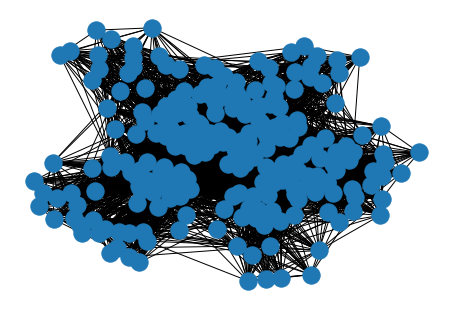

In [14]:
nx.draw(day1)
plt.show()

#### Check every node has is associated to a `class`

In [15]:
assert(all(n in labels for n in day1.nodes))

#### Set `class` attributes 

In [16]:
nx.set_node_attributes(day1, labels, NODE_ATTR)

### Extract subgraphs representing contacts/intercations by class
For every sub-graph :
* Teachers are removed
* Edges which are not connected to at least one member of the class are removed
* `NODE_ATTR` encodes  affiliation to a class
* `EDGE_ATTR`encodes the edge type (whether it connects two nodes of the given class or bridges with another class)  

In [17]:
subgraphs_day1 = extract_subgraphs(day1)

### Compute the sufficiant statistics

In [18]:
stats_day1 = compute_stats(subgraphs_day1)

In [19]:
with open('primary_school_day1.json', 'w') as file_day1:
    json.dump(stats_day1, file_day1)

## 2$^{nd}$ graph : contacts during the day 2 in a primary school

In [6]:
day2 = nx.read_gml(path="dataset/journal.pone.0023176.s004.GML", label=None)

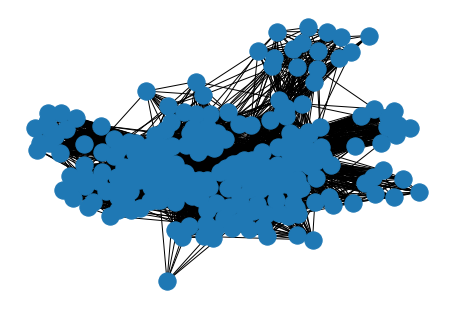

In [7]:
nx.draw(day2)
plt.show()

#### Check every node has is associated to a `class`

In [8]:
assert(all(n in labels for n in day2.nodes))

#### Set `class` attributes

In [9]:
nx.set_node_attributes(day2, labels, NODE_ATTR)

### Extract subgraphs representing contacts/intercations by class
For every sub-graph :
* Teachers are removed
* Edges which are not connected to at least one member of the class are removed
* `NODE_ATTR` encodes  affiliation to a class
* `EDGE_ATTR`encodes the edge type (whether it connects two nodes of the given class or bridges with another class)  

In [10]:
subgraphs_day2 = extract_subgraphs(day2)

In [11]:
stats_day2 = compute_stats(subgraphs_day2)

In [12]:
with open('primary_school_day2.json', 'w') as file_day2:
    json.dump(stats_day2, file_day2)